In [48]:
import os
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
DATA_FOLDER = "/home/ubuntu/mlops-zoomcamp/data"

january_data_file = os.path.join(DATA_FOLDER, 'fhv_tripdata_2021-01.parquet')
february_data_file = os.path.join(DATA_FOLDER, 'fhv_tripdata_2021-02.parquet')

In [3]:
january_data = pd.read_parquet(january_data_file)
february_data = pd.read_parquet(february_data_file)

In [4]:
january_data.shape[0]

1154112

In [5]:
january_data.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [7]:
df = january_data

In [8]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [9]:
df.duration.mean()

19.1672240937939

<AxesSubplot:ylabel='Density'>

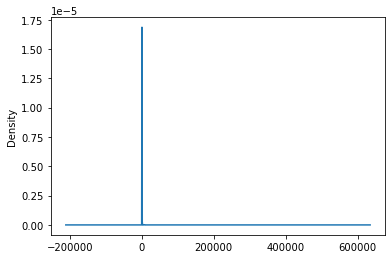

In [12]:
df.duration.plot.density()

<AxesSubplot:ylabel='Density'>

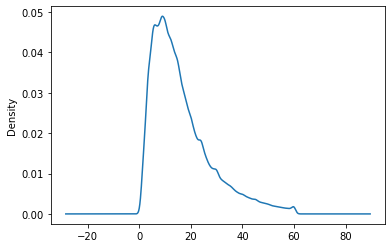

In [23]:
df[(df.duration >= 1) & (df.duration <= 60)].duration.plot.density()

In [20]:
df[(df.duration < 1) | (df.duration > 60)].shape[0]

44286

In [53]:
df.PUlocationID.value_counts(dropna=False, normalize=True) * 100

NaN      83.030676
221.0     0.740916
206.0     0.617618
129.0     0.472658
92.0      0.452642
           ...    
111.0     0.000520
34.0      0.000433
27.0      0.000347
2.0       0.000173
110.0     0.000087
Name: PUlocationID, Length: 262, dtype: float64

In [54]:
df.DOlocationID.value_counts(dropna=False, normalize=True) * 100

NaN      14.055828
76.0      2.312947
265.0     1.861691
217.0     1.702261
17.0      1.619600
           ...    
27.0      0.001733
30.0      0.001213
2.0       0.000953
105.0     0.000347
199.0     0.000087
Name: DOlocationID, Length: 263, dtype: float64

In [43]:
def preprocess_dataframe(filename: str):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PUlocationID', 'DOlocationID']
    
    return df[categorical + ['duration']].astype(str)

In [44]:
df_train = preprocess_dataframe(january_data_file)
df_val = preprocess_dataframe(february_data_file)

In [45]:
features_to_train = ['PUlocationID', 'DOlocationID']

dv = DictVectorizer()

train_dicts = df_train[features_to_train].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[features_to_train].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [46]:
X_train.shape[1]

525

In [47]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

print(f'Train dataset RMSE: {mean_squared_error(y_train, y_pred_train, squared=False)}')
print(f'Train dataset RMSE: {mean_squared_error(y_val, y_pred_val, squared=False)}')

Train dataset RMSE: 10.528519107210961
Train dataset RMSE: 11.014283204484906
